
# Polynomial chaos is sensitive to the q-norm


## Introduction

In this example, we observe the sensitivity of the polynomial chaos expansion to the total degree of the polynomial.
More precisely, we observe how this impacts the $Q^2$ predictivity coefficient.

We consider the example of the cantilever beam. We create a sparse polynomial chaos with a linear enumeration rule and the family of orthogonal polynomials corresponding to each input variable.



In [30]:
import openturns as ot
import numpy as np
import openturns.viewer
import pylab as pl
import pickle 
pl.rcParams['figure.dpi']= 500

The following parameter value leads to fast simulations.



In [2]:
maxDegree = 7

For real tests, we suggest using the following parameter value:



maxDegree = 7



Let us define the parameters of the cantilever beam problem.



In [3]:
distribution_alpha = ot.Normal(101.6612, 4.0)
distribution_alpha.setDescription([r"$\alpha$"])
#
distribution_beta = ot.Normal(0.0233, 0.0005)
distribution_beta.setDescription([r"$\beta$"])
#
distribution_epsilon_e = ot.Triangular(0.2, 0.3, 0.5)
distribution_epsilon_e.setDescription([r"$\epsilon_e$"])
#
distribution_epsilon_c = ot.Triangular(0.0, 0.05, 0.3)
distribution_epsilon_c.setDescription([r"$\epsilon_c$"])
#
dp_factor = 1.0e-6
distribution_dp = ot.Triangular(0.5 * dp_factor, 5.0 * dp_factor, 10.0 * dp_factor)
distribution_dp.setDescription([r"$d_p$"])
#
distribution_gamma_p0 = ot.Triangular(1.0e-09, 4.5e-09, 8.0e-09)
distribution_gamma_p0.setDescription([r"$\Gamma_p(0)$"])
#
distribution_av = ot.Triangular(0.1e-4, 7.8e-4, 12e-4)
distribution_av.setDescription([r"$a_v$"])
#
distributionList = [
    distribution_alpha,
    distribution_beta,
    distribution_epsilon_e,
    distribution_epsilon_c,
    distribution_dp,
    distribution_gamma_p0,
    distribution_av,
]
distribution = ot.ComposedDistribution(distributionList)
# Workaround for https://github.com/openturns/openturns/issues/2255
labels = [marginal.getDescription()[0] for marginal in distributionList]

In [4]:
dataset_BC = ot.Sample.ImportFromCSVFile('DataSet_BC.csv')
dataset_BF = ot.Sample.ImportFromCSVFile('DataSet_BF.csv')

In [5]:
inputSample = dataset_BC[:,0:7]

In [6]:
outputSample_BC = dataset_BC[:,7:]
outputSample_BF = dataset_BF[:,7:]

In [7]:
inputSample

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=969 dimension=7 description=[data_0,data_1,data_2,...,data_4,data_5,data_6] data=[[105.516,0.0225637,0.427862,...,6.74309e-06,4.08487e-09,0.00061025],[105.472,0.0239598,0.257909,...,4.75128e-06,4.59559e-09,0.000831786],[95.0086,0.0234949,0.376177,...,3.62486e-06,3.23961e-09,0.000522635],...,[98.2262,0.0226106,0.27553,...,1.65602e-06,4.5673e-09,0.000574537],[99.8236,0.0239513,0.230916,...,3.95457e-06,1.33652e-09,0.000543576],[97.4609,0.0225135,0.365324,...,8.15759e-06,1.64233e-09,0.000444797]]

The following function creates a sparse polynomial chaos with a given total degree.



In [8]:
def ComputeSparseLeastSquaresChaos(
    inputTrain, outputTrain, multivariateBasis, totalDegree, distribution
):
    """
      Create a sparse polynomial chaos based on least squares.

      * Uses the enumerate rule in basis.
      * Uses the LeastSquaresStrategy to compute the coefficients based on
        least squares.
      * Uses LeastSquaresMetaModelSelectionFactory to use the LARS selection method.
      * Uses FixedStrategy in order to keep all the coefficients that the
        LARS method selected.

    Source : https://openturns.github.io/openturns/latest/auto_meta_modeling/polynomial_chaos_metamodel/plot_chaos_cv.html
    with a bug fix: replace getStrataCumulatedCardinal with getBasisSizeFromTotalDegree

      Parameters
      ----------
      inputTrain : Sample
          The input design of experiments.
      outputTrain : Sample
          The output design of experiments.
      multivariateBasis : Basis
          The multivariate chaos basis.
      totalDegree : int
          The total degree of the chaos polynomial.
      distribution : Distribution.
          The distribution of the input variable.

      Returns
      -------
      result : PolynomialChaosResult
          The estimated polynomial chaos.
    """
    selectionAlgorithm = ot.LeastSquaresMetaModelSelectionFactory()
    projectionStrategy = ot.LeastSquaresStrategy(
        inputTrain, outputTrain, selectionAlgorithm
    )
    enumerateFunction = multivariateBasis.getEnumerateFunction()
    basisSize = enumerateFunction.getBasisSizeFromTotalDegree(totalDegree)  # OK
    adaptiveStrategy = ot.FixedStrategy(multivariateBasis, basisSize)
    chaosalgo = ot.FunctionalChaosAlgorithm(
        inputTrain, outputTrain, distribution, adaptiveStrategy, projectionStrategy
    )
    chaosalgo.run()
    result = chaosalgo.getResult()
    return result

The following function computes the sparsity rate of the polynomial chaos.
To do this, we compute the number of coefficients in the decomposition assuming a linear enumeration rule and a fixed truncation.
The sparsity rate is the complement of the ratio between the number of coefficients
selected from LARS and the total number of coefficients in the full polynomial basis.



In [9]:
def computeSparsityRate(multivariateBasis, totalDegree, chaosResult):
    """Compute the sparsity rate, assuming a FixedStrategy."""
    # Get P, the maximum possible number of coefficients
    enumfunc = multivariateBasis.getEnumerateFunction()
    P = enumfunc.getStrataCumulatedCardinal(totalDegree)
    # Get number of coefficients in the selection
    indices = chaosResult.getIndices()
    nbcoeffs = indices.getSize()
    # Compute rate
    sparsityRate = 1.0 - nbcoeffs / P
    return sparsityRate

The following functions compute and plot the Q2 predictivity coefficients within the validation plot.



In [10]:
def computeQ2Chaos(chaosResult, inputTest, outputTest, outputMarginalIndex = 0):
    """Compute the Q2 of a chaos."""
    outputDimension = outputTest.getDimension()
    if outputMarginalIndex > outputDimension:
        raise ValueError("Output marginal index ", outputMarginalIndex, " is greater than the output dimension ", 
                         outputDimension)
    metamodel = chaosResult.getMetaModel()
    val = ot.MetaModelValidation(inputTest, outputTest, metamodel)
    Q2 = val.computePredictivityFactor()[outputMarginalIndex]
    Q2 = max(Q2, 0.0)  # We are not lucky every day.
    return Q2

In [11]:
def printChaosStats(multivariateBasis, chaosResult, inputTest, outputTest, totalDegree, outputMarginalIndex = 0):
    """Print statistics of a chaos."""
    outputDimension = outputTest.getDimension()
    if outputMarginalIndex > outputDimension:
        raise ValueError("Output marginal index ", outputMarginalIndex, " is greater than the output dimension ", 
                         outputDimension)
    sparsityRate = computeSparsityRate(multivariateBasis, totalDegree, chaosResult)
    Q2 = computeQ2Chaos(chaosResult, inputTest, outputTest, outputMarginalIndex)
    metamodel = chaosResult.getMetaModel()
    val = ot.MetaModelValidation(inputTest, outputTest, metamodel)
    graph = val.drawValidation().getGraph(0, outputMarginalIndex)
    legend1 = "O=%d, D=%d, Q2=%.2f%%" % (outputMarginalIndex, totalDegree, 100 * Q2)
    graph.setLegends(["", legend1])
    graph.setLegendPosition("topleft")
    print(
        "Degree=%d, Q2=%.2f%%, Sparsity=%.2f%%"
        % (totalDegree, 100 * Q2, 100 * sparsityRate)
    )
    return graph

In [12]:
multivariateBasis = ot.OrthogonalProductPolynomialFactory(
    distributionList
)

In [13]:
def compute_Q2_score_by_splitting(
    X, Y, basis, totalDegree, distribution, split_fraction=0.75
):
    """
    Compute Q2 score by splitting into train/test sets.

    Parameters
    ----------
    X : Sample(size, input_dimension)
        The X dataset.
    Y : Sample(size, output_dimension)
        The Y dataset.

    Returns
    -------
    Q2_score : float
        The Q2 score.
    """

    training_sample_size = X.getSize()
    X_train = ot.Sample(X)
    Y_train = ot.Sample(Y)
    split_index = int(split_fraction * training_sample_size)
    X_test = X_train.split(split_index)
    Y_test = Y_train.split(split_index)
    chaosResult = ComputeSparseLeastSquaresChaos(
        X_train, Y_train, basis, totalDegree, distribution
    )
    metamodel = chaosResult.getMetaModel()
    val = ot.MetaModelValidation(X_test, Y_test, metamodel)
    Q2_score = val.computePredictivityFactor()
    Q2_local_mean = Q2_score.norm1() / Q2_score.getDimension()
    return Q2_local_mean

## Distribution of the predictivity coefficient



Let us repeat the following experiment to see the variability of the Q2 coefficient.



In [14]:
q_norm = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [15]:
for q in q_norm:
    print(q)

0.5
0.6
0.7
0.8
0.9
1.0


In [18]:
def computeSampleQ2(inputSample, outputSample, numberAttempts, q_norm, split_fraction = 0.75):
    """For a given sample size N, for degree from 1 to maxDegree,
    repeat the following experiment numberAttempts times:
    create a sparse least squares chaos and compute the Q2
    using n_valid points.
    """
    sampleSize = inputSample.getSize()
    mixingDistribution = ot.KPermutationsDistribution(sampleSize, sampleSize)
    Q2sample = ot.Sample(numberAttempts, len(q_norm))
    
    totalDegree = 4
    
    for k in range(len(q_norm)):
        q = q_norm[k]
        enumerateFunction = ot.HyperbolicAnisotropicEnumerateFunction(inputSample.getDimension(), q)
        multivariateBasis = ot.OrthogonalProductPolynomialFactory([distribution.getMarginal(i) for i in range(distribution.getDimension())], enumerateFunction
)
        print("q-norm = {}".format(q))
        for i in range(numberAttempts):
            # Randomize the sample
            X_train = ot.Sample(inputSample)
            Y_train = ot.Sample(outputSample_BC)
            newIndices = mixingDistribution.getRealization()
            X_train = X_train[newIndices]
            Y_train = Y_train[newIndices]
            # Split
            split_index = int(split_fraction * sampleSize)
            X_test = X_train.split(split_index)
            Y_test = Y_train.split(split_index)
            # Train
            chaosResult = ComputeSparseLeastSquaresChaos(
                X_train, Y_train, multivariateBasis, totalDegree, distribution
            )
            # Test
            Q2sample[i, k - 1] = compute_Q2_score_by_splitting(
                X_test, Y_test, multivariateBasis, totalDegree, distribution, split_fraction=0.75
            )
    return Q2sample

The following function uses a boxplot to see the distribution of the Q2 coefficients.



In [19]:
numberAttempts = 15  # Number of repetitions

Q2sample = computeSampleQ2(inputSample, outputSample_BF, numberAttempts, q_norm)

q-norm = 0.5
q-norm = 0.6
q-norm = 0.7
q-norm = 0.8
q-norm = 0.9
q-norm = 1.0


In [20]:
numberAttempts = 15  # Number of repetitions

Q2sample_1 = computeSampleQ2(inputSample, outputSample_BC, numberAttempts, q_norm)

q-norm = 0.5
q-norm = 0.6
q-norm = 0.7
q-norm = 0.8
q-norm = 0.9
q-norm = 1.0


In [21]:
def plotQ2Boxplots(Q2sample, N):
    data = np.array(Q2sample)
    pl.figure()
    pl.boxplot(data)
    pl.title(r"Hot branch at $z_{max}$, time-average of $Q^2$, PCE training sample size = %d" % N,fontsize=7)
    pl.xlabel(r"$p$")
    pl.ylabel(r"$m(Q^2)\;(\%)$")
    pl.ylim(0.0,1.0)
    return

Each experiment is repeated several times.



In [22]:
Q2sample_1

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=15 dimension=6 data=[[0.942343,0.96418,0.937814,0.968121,0.973502,0.92933],[0.956795,0.938551,0.963833,0.968203,0.899493,0.916113],[0.957458,0.950159,0.94732,0.924574,0.940518,0.912833],[0.936439,0.949089,0.960187,0.951191,0.953019,0.900545],[0.954858,0.963174,0.951486,0.935365,0.942467,0.902797],[0.936504,0.927329,0.957644,0.948026,0.958023,0.890142],[0.949723,0.942604,0.935557,0.941555,0.944961,0.889447],[0.955334,0.948766,0.934534,0.970717,0.963801,0.923189],[0.937754,0.901183,0.958723,0.919089,0.926423,0.846963],[0.949036,0.954886,0.973917,0.934076,0.931006,0.927866],[0.951061,0.945653,0.939976,0.974509,0.960832,0.926791],[0.944999,0.921647,0.941512,0.965046,0.961356,0.865391],[0.956953,0.947438,0.964132,0.956463,0.963897,0.936974],[0.960741,0.953594,0.962201,0.931096,0.943335,0.923999],[0.954728,0.943123,0.965102,0.956854,0.936788,0.901942]]

We see that when the size of the design of experiments is as small as 20, it is more appropriate to use a very low degree polynomial. Here 1 performs best and 4 is risky.

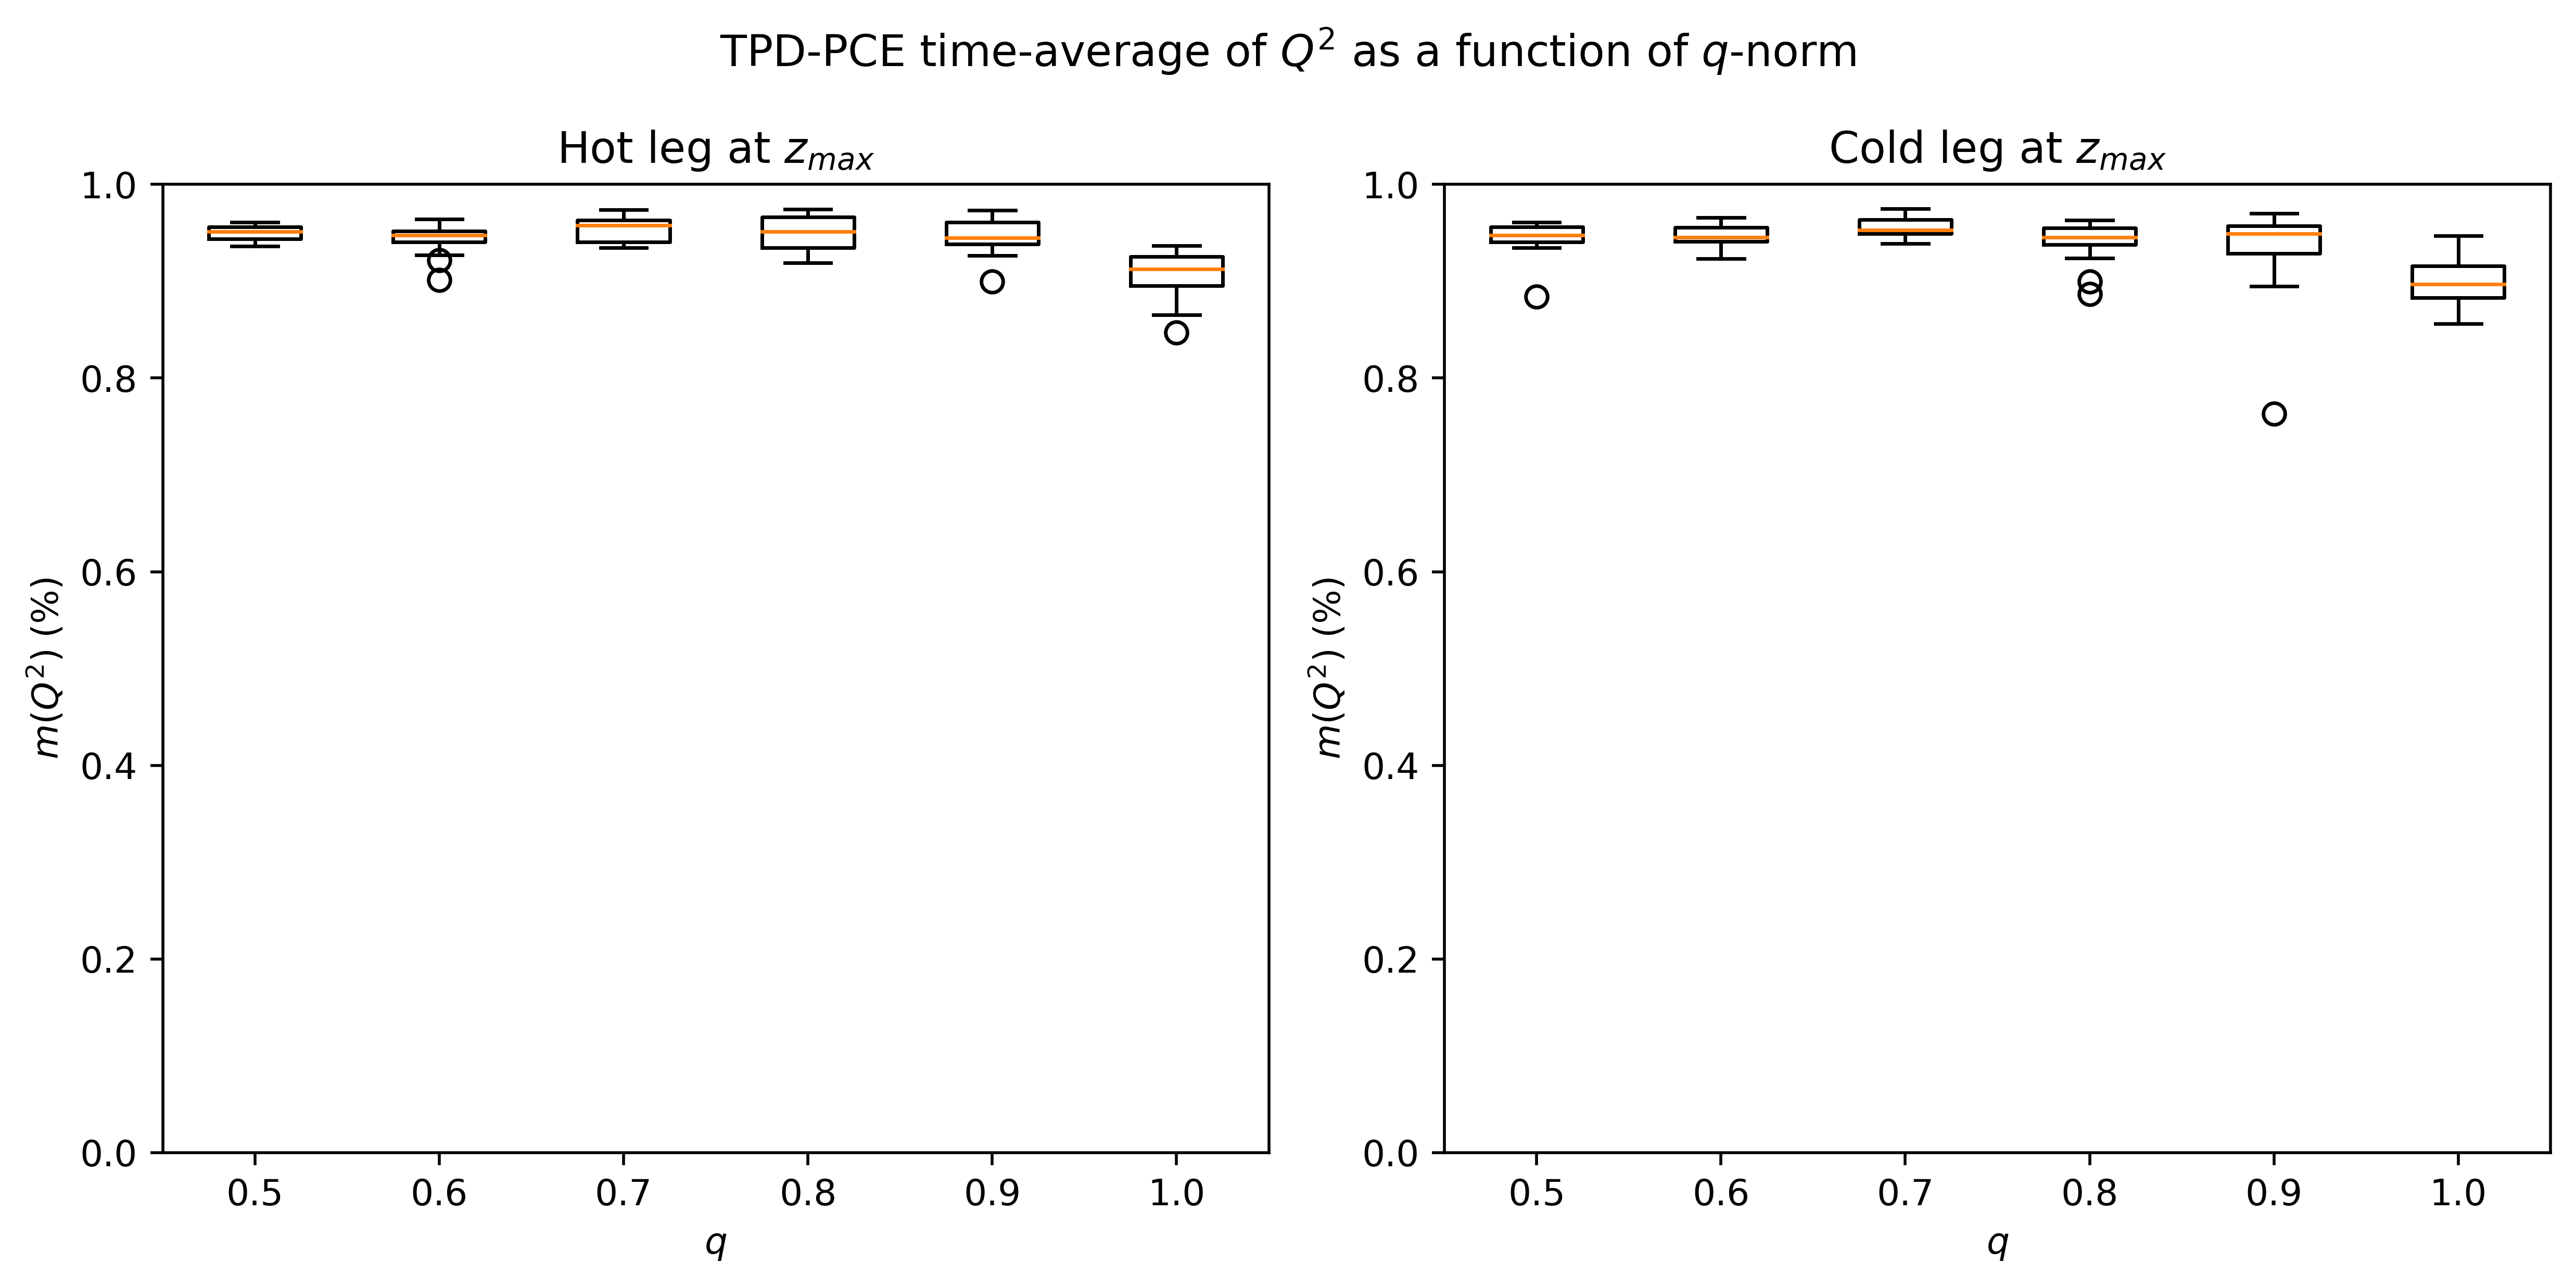

In [29]:
N = int(0.75*969)  # size of the train design
data_BF, data_BC = np.array(Q2sample), np.array(Q2sample_1)

fig, ax = pl.subplots(1,2,figsize=(10,5), layout='tight')
ax[0].boxplot(data_BC)
ax[0].set_title(r"Hot leg at $z_{max}$")
ax[0].set_ylim(0.0,1.0)
ax[0].set_xlabel(r"$q$")
ax[0].set_ylabel(r"$m(Q^2)\;(\%)$")
ax[0].set_xticks([1,2,3,4,5,6], q_norm)

ax[1].boxplot(data_BF)
ax[1].set_title(r"Cold leg at $z_{max}$")
ax[1].set_ylim(0.0,1.0)
ax[1].set_xlabel(r"$q$")
ax[1].set_ylabel(r"$m(Q^2)\;(\%)$")
ax[1].set_xticks([1,2,3,4,5,6], q_norm)


fig.suptitle(r"TPD-PCE time-average of $Q^2$ as a function of $q$-norm")

fig.savefig('TPD_pce_q_norm_sensitivit.pdf',format='pdf')

In [32]:
with open("Q2_q_norm_BC.pkl", "wb") as f:
    pickle.dump(data_BC, f)

In [33]:
with open("Q2_q_norm_BF.pkl", "wb") as f:
    pickle.dump(data_BF, f)

With a 30-point design set, a polynomial degree of 2 is usually advisable.



When the sample size increases, the Q2 computation becomes less sensitive to the polynomial degree.



## Conclusion

We observe that on the cantilever beam example, to use a polynomial total
degree equal to 4, we need a sample size at least equal to 50 to get a
satisfactory and reproducible Q2.
When the degree is equal to 4, if the sample is small, then depending on the
particular sample, the predictivity coefficient can be very low (i.e. less than 0.5).
With a sample size as small as 20, a polynomial degree of 1 is safer.
However the limited sample size may have an impact on other statistics that
could be derived from a metamodel calculated on such a small training sample.

## References

* "Metamodel-Based Sensitivity Analysis: Polynomial Chaos Expansions and Gaussian Processes", Loïc Le Gratiet, Stefano Marelli, Bruno Sudret,
  Handbook of Uncertainty Quantification, 2017, Springer International Publishing.


